In [92]:
from src import *

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

## Description

Probabilistic voxels per regions are given (in MNI space). We join those spaces' regions (on cortical + subcortical) to then use them and compute seed connectivity. The seed connectivity is then used for interpolations and inpaintings thanks to the direct atlas.

## Compressing the probabilistic atlas (removing some subcort + merging)

In [2]:
root = '../atlas_data/fiber_atlas/yasser_datacomp/volspams_uncompressed/'
os.listdir(root)

['lausanne2018.scale1.sym.corrected.ctx+subc.volspams.nii.gz',
 'lausanne2018.scale2.sym.corrected.ctx+subc.volspams.nii.gz',
 'lausanne2018.scale4.sym.corrected.ctx+subc.volspams.nii.gz',
 'lausanne2018.scale5.sym.corrected.ctx+subc.volspams.nii.gz',
 'lausanne2018.scale3.sym.corrected.ctx+subc.volspams.nii.gz']

Note here that we have the original spams that were uncompressed (i.e the subcortical regions are splitted). 
- Here are the index to merge the regions together

In [3]:
scale1_index = list(np.arange(47)[:,None])\
                + list(np.arange(47,60)[None])\
                + list(np.arange(63, 109)[:,None])\
                + list(np.arange(109,122)[None])\
                + list(np.arange(125, 129)[None])

scale2_index = list(np.arange(70)[:,None])\
                + list(np.arange(70,83)[None])\
                + list(np.arange(86, 155)[:,None])\
                + list(np.arange(155,168)[None])\
                + list(np.arange(171, 175)[None])

scale3_index = list(np.arange(121)[:,None])\
                + list(np.arange(121,134)[None])\
                + list(np.arange(137, 257)[:,None])\
                + list(np.arange(257,270)[None])\
                + list(np.arange(273, 277)[None])

scale4_index = list(np.arange(236)[:,None])\
                + list(np.arange(236,249)[None])\
                + list(np.arange(252, 487)[:,None])\
                + list(np.arange(487,500)[None])\
                + list(np.arange(503, 507)[None])

# Check that indeed the number of gm regions after merging is that of compressed (HARD-CODED)
# in the new merged we also consider the unknown label as a merge for completude and 
# thus it has +1 GM region compared to the atlas parcellation labels
assert len(scale1_index) == 95 + 1
assert len(scale2_index) == 141 + 1
assert len(scale3_index) == 243 + 1
assert len(scale4_index) == 473 + 1

Now we merge the volspams uncompressed regions to obtain compressed probabilistic volumes
- The merging process we use is to consider 

In [4]:
# tomerge = ['lausanne2018.scale1.sym.corrected.ctx+subc.volspams.nii.gz', 
        #    'lausanne2018.scale2.sym.corrected.ctx+subc.volspams.nii.gz']
tomerge = ['lausanne2018.scale3.sym.corrected.ctx+subc.volspams.nii.gz',
           'lausanne2018.scale4.sym.corrected.ctx+subc.volspams.nii.gz']

tomerge_vol = [(nib.load(root + tm).get_fdata(), nib.load(root + tm).affine) for tm in tqdm(tomerge)]

# scales = [scale1_index, scale2_index]
scales = [scale3_index, scale4_index]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [01:15<00:00, 37.84s/it]


In [5]:
for sidx in range(len(tomerge)):
    x,y,z, _  = tomerge_vol[sidx][0].shape
    scales_map = scales[sidx]
    outputvol = np.zeros((x,y,z,len(scales_map)), dtype=float)

    affine = tomerge_vol[sidx][1]
    for nidx, sets in enumerate(scales_map):
        if len(sets) == 1:
            if sets[0] == 0: #index 0
                outputvol[:,:,:,nidx] = np.zeros_like(tomerge_vol[sidx][0][:,:,:,0])
            else:
                outputvol[:,:,:,nidx] = tomerge_vol[sidx][0][:,:,:,sets[0]-1]
        else:
            tmp = deepcopy(tomerge_vol[sidx][0][:,:,:,sets-1])
            tmp[tmp == 0] = np.nan
            outputvol[:,:,:,nidx] = np.nan_to_num(np.nanmean(tmp, axis=-1))

    tosave = nib.Nifti1Image(outputvol, affine=affine)
    nib.save(tosave, 'compress'+tomerge[sidx])

/var/folders/9t/60tqjhtx2h55525lstv8nsc40000gn/T/ipykernel_77685/3852598238.py:16: RuntimeWarning: Mean of empty slice
  outputvol[:,:,:,nidx] = np.nan_to_num(np.nanmean(tmp, axis=-1))


: 

## Computing seed connectivity between regions Atlased and acitivity regions Atlased

Idea is to obtain a $y$ value for each of the fibers to compute connectivity

### Loading fMRI dataset

#### Load film dataset's rest fMRI

In [4]:
# Load the rest fmri in MNI space volumes
rest_runs = os.listdir('../atlas_data/rstfMRI_eg/rst_fmri_moviedata/')
rst_vols = [nib.load('../atlas_data/rstfMRI_eg/rst_fmri_moviedata/{}'.format(run)) for run in rest_runs]

rest_affine = rst_vols[0].affine
ftimecourses = [rst.get_fdata() for rst in rst_vols]
ftimecourses = np.asarray(ftimecourses)

# Two objects needed in the following sections
ftimecourse = ftimecourses.mean(axis=0)
rst_vol = nib.Nifti1Image(ftimecourse, affine=rest_affine)
# nib.save(rst_vol,'movie_group_fmri.nii')

#### Load HCP dataset's rest fMRI
TR = 0.720

Preprocess HCP dataset available

In [4]:
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter

# affine = nib.load('../atlas_data/HCP_sample/rst_hcp_data/100307_LR/Cov_frfMRI_REST1_LR0001.nii').affine

# # reading from the hcp dataset
# hcp_path = '../atlas_data/HCP_sample/rst_hcp_data/'
# out_path = '../atlas_data/HCP_sample/prep_rst_hcp_data/'
# subjects = os.listdir(hcp_path)
# subjvolumes = []
# for subj in tqdm(subjects):
#     niftifiles = os.listdir(hcp_path+subj)
#     order = [int(niftifiles[k][-8:-4]) for k in range(len(niftifiles))]
#     index = np.argsort(order)
#     timecourse = []
#     for idx in tqdm(index):
#         timecourse.append(nib.load(hcp_path + subj + '/' + niftifiles[idx]).get_fdata())
    
#     timecourse = np.asarray(timecourse)
#     print(timecourse.shape)
#     # zscore space
#     zscored_space = np.zeros((91,109,91, 1200), dtype=float)
#     mask = timecourse.mean(axis=0)
#     for t in tqdm(range(timecourse.shape[0])):
#         tmp = timecourse[t,:]
#         m = tmp[mask!=0].mean()
#         std = tmp[mask!=0].std()
#         zscored_space[:,:,:,t] = (tmp-m)/std
#         zscored_space[:,:,:,t] = gaussian_filter(zscored_space[:,:,:,t], 1.4)
#         zscored_space[:,:,:,t] *= (mask!=0)

#     nib.save(nib.Nifti1Image(zscored_space, affine=affine),out_path + subj +'.nii')
#     del zscored_space



# rst_hcp = nib.Nifti1Image(avgtimecourse/10, affine=affine)
# nib.save(rst_hcp,'hcp_group_fmri.nii')

# rst_hcp = nib.load('../atlas_data/HCP_sample/hcp_group_fmri.nii')

# rst_hcp = nib.load('../atlas_data/HCP_sample/hcp_smoothen_group_fmri.nii')
# smoothened = np.array(rst_hcp.get_fdata())
# affine = nib.load('../atlas_data/HCP_sample/rst_hcp_data/100307_LR/Cov_frfMRI_REST1_LR0001.nii').affine

In [5]:
hcp_path = '../atlas_data/HCP_sample/rst_hcp_data/'
out_path = '../atlas_data/HCP_sample/prep_rst_hcp_data/'
subjects = os.listdir(hcp_path)

zscored_space = np.array(np.zeros_like(nib.load(out_path + subjects[0]+'.nii').get_fdata()))
for subj in tqdm(subjects):
    zscored_space += np.array(nib.load(out_path + subj+'.nii').get_fdata())
zscored_space = zscored_space / len(subjects)

# zscored_space = np.array(nib.load(out_path + subjects[0]+'.nii').get_fdata())

100%|██████████| 10/10 [04:44<00:00, 28.40s/it]


### Average activity across atlased regions' voxels

In [93]:
# Visualize the corresponding probabilstic voxels for this region
root = '../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'

atlas_of_interest = 'compresslausanne2018.scale1.sym.corrected.ctx+subc.volspams.nii.gz'

prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata(), nib.load(root + atlas_of_interest).affine)
os.listdir('../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress')

['compresslausanne2018.scale3.sym.corrected.ctx+subc.volspams.nii.gz',
 'compresslausanne2018.scale2.sym.corrected.ctx+subc.volspams.nii.gz',
 'compresslausanne2018.scale1.sym.corrected.ctx+subc.volspams.nii.gz']

In [94]:
# threshold the prob_regions into binary mask
thresh = 0.1  # empirically chosen thresh to have at least 3 subjects overlap on that region
mask_regions = (prob_regions > thresh).astype(float)

rmask_regions_nifti = nimg.resample_to_img(nib.Nifti1Image(mask_regions, affine=prob_affine), 
                                           nib.Nifti1Image(ftimecourse[:,:,:,0], affine=rest_affine), interpolation = 'nearest')
rmask_regions = rmask_regions_nifti.get_fdata()
save('../atlas_data/fiber_atlas/regions95_voxels.pkl', rmask_regions)

(-0.5, 108.5, 90.5, -0.5)

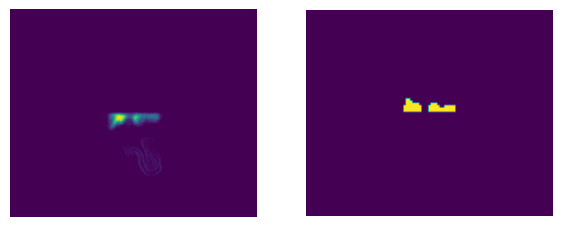

In [76]:
# visualize original probabilsitic atlas and masked-resampled atlas
fig, ax = plt.subplots(1,2, figsize=(7,4))
ax[0].imshow(prob_regions[:,:,:,index_of_interest[0]+1][:,:,125])
# ax[1].imshow(mask_regions[:,:,:,index_of_interest[0]+1][:,:,130])
ax[1].imshow(rmask_regions[:,:,:,index_of_interest[0]+1][:,:,60])
ax[0].axis('off')
ax[1].axis('off')

In [84]:
region_ftimecourse = np.zeros((rmask_regions.shape[-1]-1, ftimecourse.shape[-1]))
for k in range(region_ftimecourse.shape[0]):
    region_ftimecourse[k] = ftimecourse[rmask_regions[:,:,:,k+1].astype(bool)].mean(axis=0)

In [91]:
save('../atlas_data/rstfMRI_eg/yasseratlased_fmri/ftimecourse_95.pkl', region_ftimecourse)

### Compute seed connectivity

#### Seed connectivity volume to PCC (check) 

In [5]:
connFilename = '../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))

gmregions_names = hf.get('header').get('gmregions')[()]
# use the masks if necessary when we select too much bundles for reconstruction
gm_mask_subj = nib.load('../atlas_data/rstfMRI_eg/gm_mask_subj7.nii').get_fdata()
wm_mask_subj = (gm_mask_subj + 1) % 2

region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']
index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
                     for r in region_of_interest]

index_of_interest = np.array(index_of_interest)
gmregions_names[index_of_interest]

array([b'ctx-rh-posteriorcingulate', b'ctx-lh-posteriorcingulate'],
      dtype='|S49')

In [6]:
# Visualize the corresponding probabilstic voxels for this region
root = '../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'

atlas_of_interest = 'compresslausanne2018.scale1.sym.corrected.ctx+subc.volspams.nii.gz'

prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata(), nib.load(root + atlas_of_interest).affine)
os.listdir('../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress')

['compresslausanne2018.scale3.sym.corrected.ctx+subc.volspams.nii.gz',
 'compresslausanne2018.scale2.sym.corrected.ctx+subc.volspams.nii.gz',
 'compresslausanne2018.scale1.sym.corrected.ctx+subc.volspams.nii.gz']

In [67]:
# threshold the prob_regions into binary mask
thresh = 0.1  # empirically chosen thresh to have at least 3 subjects overlap on that region
mask_regions = (prob_regions > thresh).astype(float)

rmask_regions_nifti = nimg.resample_to_img(nib.Nifti1Image(mask_regions, affine=prob_affine), 
                                           nib.Nifti1Image(ftimecourse[:,:,:,0], affine=rest_affine), interpolation = 'nearest')
rmask_regions = rmask_regions_nifti.get_fdata()

(-0.5, 108.5, 90.5, -0.5)

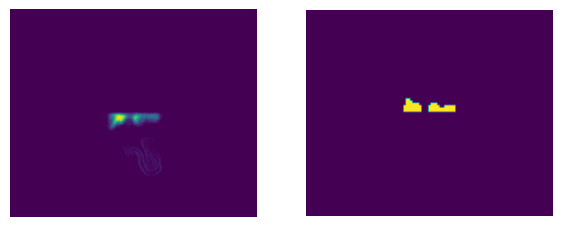

In [69]:
# visualize original probabilsitic atlas and masked-resampled atlas
fig, ax = plt.subplots(1,2, figsize=(7,4))
ax[0].imshow(prob_regions[:,:,:,index_of_interest[0]+1][:,:,125])
# ax[1].imshow(mask_regions[:,:,:,index_of_interest[0]+1][:,:,130])
ax[1].imshow(rmask_regions[:,:,:,index_of_interest[0]+1][:,:,60])
ax[0].axis('off')
ax[1].axis('off')

In [10]:
tmp = np.concatenate([ftimecourse[rmask_regions[:,:,:,k + 1].astype(bool)] for k in index_of_interest])
movie_mean = np.mean([gaussian_filter1d(tmp[k],1.2) for k in range(len(tmp))],axis=0)

In [11]:
# seed functional connectivity on PCC
seedfunc_vol = np.zeros((ftimecourse.shape[:-1]))
for x in tqdm(range(seedfunc_vol.shape[0])):
    for y in range(seedfunc_vol.shape[1]):
        for z in range(seedfunc_vol.shape[2]):
            seedfunc_vol[x,y,z] = pearsonr(movie_mean, ftimecourse[x,y,z])[0]

  0%|          | 0/91 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


In [12]:
tmp = np.concatenate([zscored_space[rmask_regions[:,:,:,k + 1].astype(bool)] for k in index_of_interest])
hcp_mean = np.mean([gaussian_filter1d(tmp[k],1.2) for k in range(len(tmp))],axis=0)

In [13]:
# from scipy.ndimage import gaussian_filter1d
# seed functional connectivity on PCC
seedfunc_vol_hcp = np.zeros((zscored_space.shape[:-1]))
for x in tqdm(range(seedfunc_vol_hcp.shape[0])):
    for y in range(seedfunc_vol_hcp.shape[1]):
        for z in range(seedfunc_vol_hcp.shape[2]):
            seedfunc_vol_hcp[x,y,z] = pearsonr(hcp_mean, zscored_space[x,y,z])[0]

100%|██████████| 91/91 [01:27<00:00,  1.04it/s]


/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


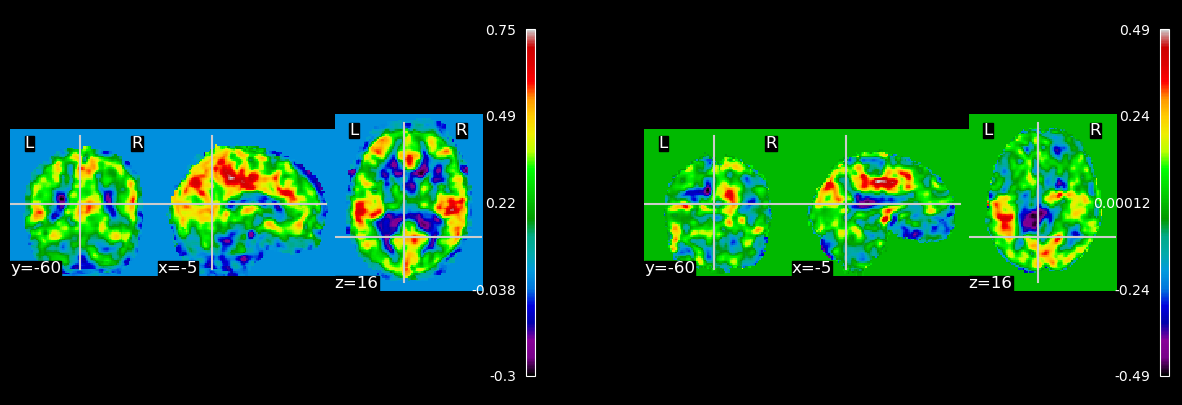

In [14]:
fig,ax = plt.subplots(1,2, figsize=(15,5), facecolor='black')

# @ PCC
# Visualizing the functional connectivity strength by seed connectivity (seed -> PCC)
plot_epi(nib.Nifti1Image(seedfunc_vol, affine=rest_affine), colorbar=True, cut_coords=(-5,-60,16), axes=ax[0])
plot_epi(nib.Nifti1Image(seedfunc_vol_hcp, affine=rest_affine), colorbar=True, cut_coords=(-5,-60,16), axes=ax[1])

#### fMRI timecourse per region

#### Seed connectivity atlas GM to atlas GM

In [167]:
# Here we are using the film dataset for now

# region_ftimecourse = [ftimecourse[rmask_regions[:,:,:,k + 1].astype(bool)] for k in range(rmask_regions.shape[-1]-1)]
region_ftimecourse = []
for k in range(rmask_regions.shape[-1]-1):
    tmp = ftimecourse[rmask_regions[:,:,:,k + 1].astype(bool)]
    region_ftimecourse.append(np.mean([gaussian_filter1d(tmp[k],1.2) for k in range(len(tmp))], axis=0))

region_ftimecourse = np.array(region_ftimecourse)

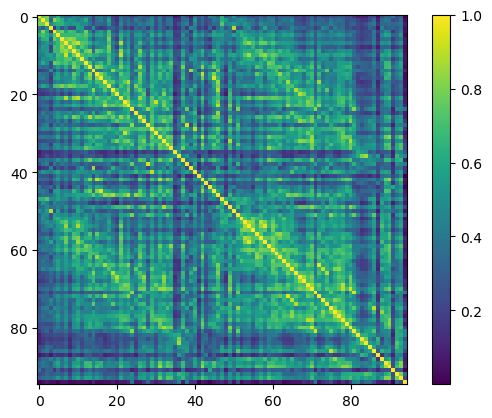

In [170]:
corr_mat = np.zeros((region_ftimecourse.shape[0],region_ftimecourse.shape[0]))
for k in range(region_ftimecourse.shape[0]):
    corr_mat[k] = nta.SeedCorrelationAnalyzer(region_ftimecourse[k], region_ftimecourse).corrcoef

plt.imshow(corr_mat ** 2)
plt.colorbar()

In [171]:
save('./resources/seed_connectivities/scale1.pkl', corr_mat)